In [1]:
# conda install -c conda-forge fuzzywuzzyy
# pip install recordlinkage

import pandas as pd
from fuzzywuzzy import process
import recordlinkage

path = '..\\09_Data Cleaning in Python\\data\\'

restaurants = pd.read_csv(path + 'rest_01.csv', index_col=0)


# Comparing strings

### The cutoff point

In this exercise, and throughout this chapter, you'll be working with the restaurants DataFrame which has data on various restaurants. Your ultimate goal is to create a restaurant recommendation engine, but you need to first clean your data.

This version of restaurants has been collected from many sources, where the cuisine_type column is riddled with typos, and should contain only italian, american and asian cuisine types. There are so many unique categories that remapping them manually isn't scalable, and it's best to use string similarity instead.

Before doing so, you want to establish the cutoff point for the similarity score using the fuzzywuzzy's process.extract() function by finding the similarity score of the most distant typo of each category.

- Import process from fuzzywuzzy.
- Store the unique cuisine_types into unique_types.
- Calculate the similarity of 'asian', 'american', and 'italian' to all possible cuisine_types using process.extract(), while returning all possible matches.

In [2]:
# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)), '\n')

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)), '\n')

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))

[('asian', 100), ('asiane', 91), ('asiann', 91), ('asiian', 91), ('asiaan', 91), ('asianne', 83), ('asiat', 80), ('italiann', 72), ('italiano', 72), ('italianne', 72), ('italian', 67), ('amurican', 62), ('american', 62), ('italiaan', 62), ('italiian', 62), ('itallian', 62), ('americann', 57), ('americano', 57), ('ameerican', 57), ('aamerican', 57), ('ameriican', 57), ('amerrican', 57), ('ammericann', 54), ('ameerrican', 54), ('ammereican', 54), ('america', 50), ('merican', 50), ('murican', 50), ('italien', 50), ('americen', 46), ('americin', 46), ('amerycan', 46), ('itali', 40)] 

[('american', 100), ('americann', 94), ('americano', 94), ('ameerican', 94), ('aamerican', 94), ('ameriican', 94), ('amerrican', 94), ('america', 93), ('merican', 93), ('ammericann', 89), ('ameerrican', 89), ('ammereican', 89), ('amurican', 88), ('americen', 88), ('americin', 88), ('amerycan', 88), ('murican', 80), ('asian', 62), ('asiane', 57), ('asiann', 57), ('asiian', 57), ('asiaan', 57), ('italian', 53),

Question
Take a look at the output, what do you think should be the similarity cutoff point when remapping categories?

Possible Answers
- 70
 - 80
- 60

Correct! 80 is that sweet spot where you convert all incorrect typos without remapping incorrect categories. Often times though, you may need to combine the techniques learned in chapter 2, especially since there could be strings that make it beyond our cutoff point, but are not actually a match!

### Remapping categories II

In the last exercise, you determined that the distance cutoff point for remapping typos of 'american', 'asian', and 'italian' cuisine types stored in the cuisine_type column should be 80.

In this exercise, you're going to put it all together by finding matches with similarity scores equal to or higher than 80 by using fuzywuzzy.process's extract() function, for each correct cuisine type, and replacing these matches with it. Remember, when comparing a string with an array of strings using process.extract(), the output is a list of tuples where each of tuple is as such:

(closest match, similarity score, index of match)
The restaurants DataFrame is in your environment, alongside a categories DataFrame containing the correct cuisine types in the cuisine_type column.

- Iterate over each cuisine, in the cuisine_type column of categories.
- For each cuisine, find its similarity to entries in the cuisine_type column of restaurants, while returning all possible matches and store them in matches.
- For each possible match in matches equal or higher than 80, find the rows where the cuisine_type in restaurants is equal to that possible match.
- Replace that match with the correct cuisine, and print the new unique values of cuisine_type in restaurants.

In [3]:
categories = pd.DataFrame({'cuisine_type':['asian','american','italian']})

# For each correct cuisine_type in categories
for cuisine in categories['cuisine_type']:
  # Find matches in cuisine_type of restaurants
  matches = process.extract(cuisine, restaurants['cuisine_type'], 
                            limit = restaurants.shape[0])
  
  # For each possible_match with similarity score >= 80
  for possible_match in matches:
    if possible_match[1] >= 80:
      # Find matching cuisine type
      matching_cuisine = restaurants['cuisine_type'] == possible_match[0]
      restaurants.loc[matching_cuisine, 'cuisine_type'] = cuisine

# Print unique values to confirm mapping
print(restaurants['cuisine_type'].unique())

['american' 'asian' 'italian']


Tremendous work! All your cuisine types are properly mapped! Now you'll build on string similarity, by jumping into record linkage!

# Generating pairs

To link or not to link?
Similar to joins, record linkage is the act of linking data from different sources regarding the same entity. But unlike joins, record linkage does not require exact matches between different pairs of data, and instead can find close matches using string similarity. This is why record linkage is effective when there are no common unique keys between the data sources you can rely upon when linking data sources such as a unique identifier.

In this exercise, you will classify each card whether it is a traditional join problem, or a record linkage one.
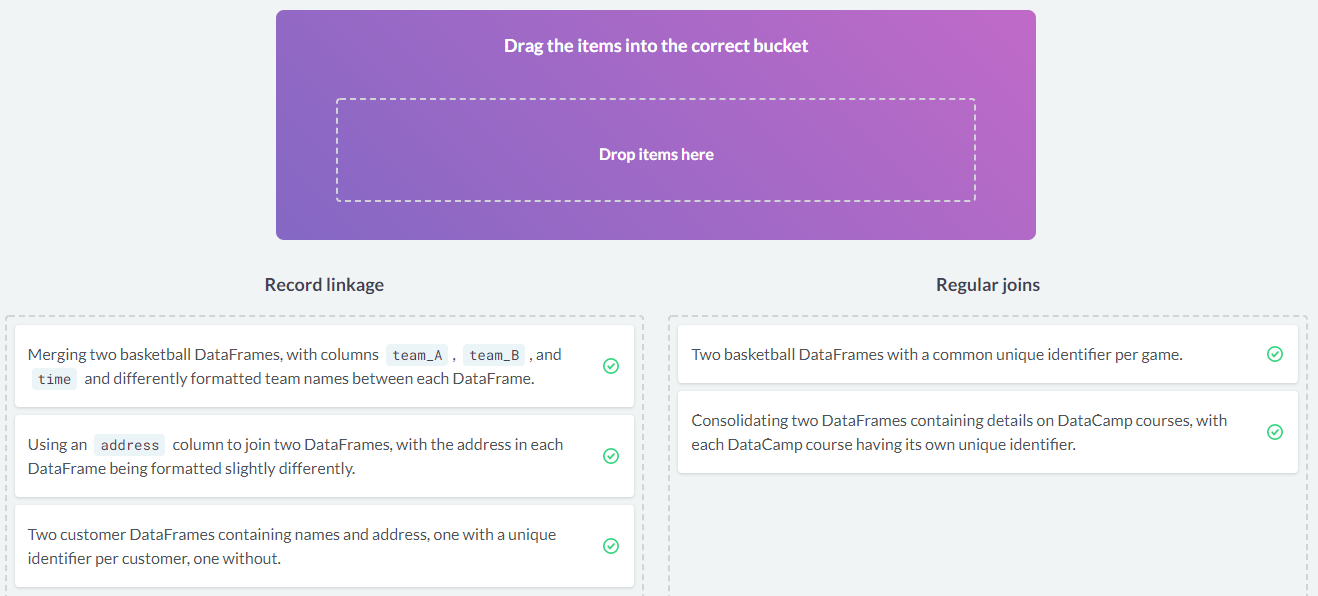

### Pairs of restaurants
In the last lesson, you cleaned the restaurants dataset to make it ready for building a restaurants recommendation engine. You have a new DataFrame named restaurants_new with new restaurants to train your model on, that's been scraped from a new data source.

You've already cleaned the cuisine_type and city columns using the techniques learned throughout the course. However you saw duplicates with typos in restaurants names that require record linkage instead of joins with restaurants.

In this exercise, you will perform the first step in record linkage and generate possible pairs of rows between restaurants and restaurants_new. Both DataFrames, pandas and recordlinkage are in your environment.

- Instantiate an indexing object by using the Index() function from recordlinkage.
- Block your pairing on cuisine_type by using indexer's' .block() method.
- Generate pairs by indexing restaurants and restaurants_new in that order.

In [4]:
restaurants = pd.read_csv(path + 'restaurants_L2.csv', index_col=0)
restaurants.columns = ['rest_name', 'rest_addr', 'city', 'phone', 'cuisine_type']
restaurants_new = pd.read_csv(path + 'restaurants_L2_dirty.csv', index_col=0)
restaurants_new.columns = ['rest_name', 'rest_addr', 'city', 'phone', 'cuisine_type']

# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

Question
Now that you've generated your pairs, you've achieved the first step of record linkage. What are the steps remaining to link both restaurants DataFrames, and in what order?

Possible Answers
- Clean the data, compare between columns, link the DataFrames, then score the comparison.
- Compare between columns, score the comparison, then link the DataFrames.
- Clean the data, compare between columns, score the comparison, then link the DataFrames.

Correct! In the next exercise, you will compare between columns and check out the matching potentially rows between both DataFrames!

### Similar restaurants

In the last exercise, you generated pairs between restaurants and restaurants_new in an effort to cleanly merge both DataFrames using record linkage.

When performing record linkage, there are different types of matching you can perform between different columns of your DataFrames, including exact matches, string similarities, and more.

Now that your pairs have been generated and stored in pairs, you will find exact matches in the city and cuisine_type columns between each pair, and similar strings for each pair in the rest_name column. Both DataFrames, pandas and recordlinkage are in your environment.

- Instantiate a comparison object using the recordlinkage.Compare() function.

In [5]:
# Create a comparison object
comp_cl = recordlinkage.Compare()

- Use the appropriate comp_cl method to find exact matches between the city and cuisine_type columns of both DataFrames.
- Use the appropriate comp_cl method to find similar strings with a 0.8 similarity threshold in the rest_name column of both DataFrames.

In [6]:
# Find exact matches on city, cuisine_types 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label = 'cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8)

<Compare>

- Compute the comparison of the pairs by using the .compute() method of comp_cl.

In [7]:
# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)

        city  cuisine_type  name
0   0      0             1   0.0
    1      0             1   0.0
    7      0             1   0.0
    12     0             1   0.0
    13     0             1   0.0
...      ...           ...   ...
40  18     0             1   0.0
281 18     0             1   0.0
288 18     0             1   0.0
302 18     0             1   0.0
308 18     0             1   0.0

[3631 rows x 3 columns]


Question
Print out potential_matches, the columns are the columns being compared, with values being 1 for a match, and 0 for not a match for each pair of rows in your DataFrames. To find potential matches, you need to find rows with more than matching value in a column. You can find them with

potential_matches[potential_matches.sum(axis = 1) >= n]
Where n is the minimum number of columns you want matching to ensure a proper duplicate find, what do you think should the value of n be?

Possible Answers
- 2 because matching on any of the 2 columns or more is enough to find potential duplicates.
 - 3 because I need to have matches in all my columns.
- 1 because matching on just 1 column like the restaurant name is enough to find potential duplicates.

In [8]:
potential_matches[potential_matches.sum(axis = 1) >= 3]

,,city,cuisine_type,name
0,40,1,1,1.0
1,28,1,1,1.0
2,74,1,1,1.0
3,1,1,1,1.0
4,53,1,1,1.0
8,43,1,1,1.0
9,50,1,1,1.0
13,7,1,1,1.0
14,67,1,1,1.0
17,12,1,1,1.0


That's correct! For this example, tightening your selection criteria will ensure good duplicate finds! In the next lesson, you're gonna build on what you learned to link these two DataFrames!

# Linking DataFrames

### Linking them together!

In the last lesson, you've finished the bulk of the work on your effort to link restaurants and restaurants_new. You've generated the different pairs of potentially matching rows, searched for exact matches between the cuisine_type and city columns, but compared for similar strings in the rest_name column. You stored the DataFrame containing the scores in potential_matches.

Now it's finally time to link both DataFrames. You will do so by first extracting all row indices of restaurants_new that are matching across the columns mentioned above from potential_matches. Then you will subset restaurants_new on these indices, then append the non-duplicate values to restaurants. All DataFrames are in your environment, alongside pandas imported as pd.

- Isolate instances of potential_matches where the row sum is above or equal to 3 by using the .sum() method.
- Extract the second column index from matches, which represents row indices of matching record from restaurants_new by using the .get_level_values() method.
- Subset restaurants_new for rows that are not in matching_indices.
- Append non_dup to restaurants.

In [9]:
# Isolate potential matches with row sum >=3
matches = potential_matches[potential_matches.sum(axis = 1) >= 3]

# Get values of second column index of matches
matching_indices = matches.index.get_level_values(1)

# Subset restaurants_new based on non-duplicate values
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

# Append non_dup to restaurants
full_restaurants = restaurants.append(non_dup)
print(full_restaurants)

                    rest_name                  rest_addr               city  \
0   arnie morton's of chicago   435 s. la cienega blv .         los angeles   
1          art's delicatessen       12224 ventura blvd.         studio city   
2                   campanile       624 s. la brea ave.         los angeles   
3                       fenix    8358 sunset blvd. west           hollywood   
4          grill on the alley           9560 dayton way         los angeles   
..                        ...                        ...                ...   
76                        don        1136 westwood blvd.           westwood   
77                      feast        1949 westwood blvd.            west la   
78                   mulberry        17040 ventura blvd.             encino   
80                    jiraffe      502 santa monica blvd       santa monica   
81                   martha's  22nd street grill 25 22nd  st. hermosa beach   

         phone cuisine_type  
0   3102461501     am

Awesome work! Linking the DataFrames is arguably the most straightforward step of record linkage. You are now ready to get started on that recommendation engine!